# PyTorch Multivariate LSTMs
https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

Each row probably consists of several different columns; 
these are the features, or predictors, that we have information about at each time step. 
One of these columns is not a feature, however. It is the target we want to predict.

# Load and PreProcess Data

In [2]:
import os
import pandas as pd

len_in_seq = 50
len_out_seq = 10

path_to_file = os.path.join(os.getcwd(), 'data.csv')
df = pd.read_csv(path_to_file, index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2021-09-14,44960.050781,47218.125000,44752.332031,47092.492188,38652152880
2021-09-15,47098.000000,48450.468750,46773.328125,48176.347656,30484496466
2021-09-16,48158.906250,48486.828125,47079.558594,47783.359375,31764293754
2021-09-17,47771.003906,48160.921875,46832.523438,47267.519531,28727713711
2021-09-18,47273.527344,48791.781250,47087.285156,48278.363281,28575630451


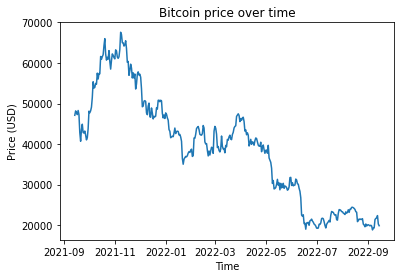

In [3]:
import matplotlib.pyplot as plt

plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show()

In [4]:
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((366, 4), (366,))

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [6]:
import numpy as np

# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, len_in_seq, len_out_seq)
print(X_ss.shape, y_mm.shape)

(308, 50, 4) (308, 10)


In [7]:
#assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

In [8]:
total_samples = len(X)
#train_test_cutoff = round(0.90 * total_samples)

train_test_cutoff = len_in_seq + len_out_seq

X_train = X_ss[:-train_test_cutoff]
X_test = X_ss[-train_test_cutoff:]

y_train = y_mm[:-train_test_cutoff]
y_test = y_mm[-train_test_cutoff:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (248, 50, 4) (248, 10)
Testing Shape: (60, 50, 4) (60, 10)


In [9]:
import torch
from torch.autograd import Variable

# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], len_in_seq, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], len_in_seq, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([248, 50, 4]) torch.Size([248, 10])
Testing Shape: torch.Size([60, 50, 4]) torch.Size([60, 10])


In [11]:
#X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
#X_check[-1][0:4]
#X.iloc[-149:-145]

# LSTM Model

In [12]:
import torch.nn as nn

class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [13]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item()))

In [14]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = len_out_seq # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [15]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.27930, test loss: 0.02190
Epoch: 100, train loss: 0.01397, test loss: 0.02506
Epoch: 200, train loss: 0.00681, test loss: 0.00292
Epoch: 300, train loss: 0.00484, test loss: 0.00237
Epoch: 400, train loss: 0.00435, test loss: 0.00236
Epoch: 500, train loss: 0.00409, test loss: 0.00222
Epoch: 600, train loss: 0.00391, test loss: 0.00211
Epoch: 700, train loss: 0.00377, test loss: 0.00190
Epoch: 800, train loss: 0.00366, test loss: 0.00172
Epoch: 900, train loss: 0.00358, test loss: 0.00165


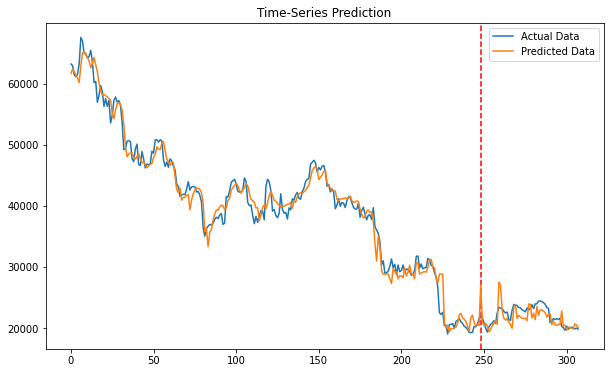

In [20]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, len_in_seq, len_out_seq)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], len_in_seq, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0]) # take the first predicted time step!!! which is optimistic!
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=len(data_predict)-train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 

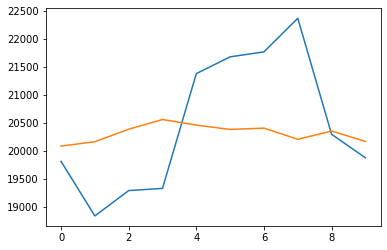

In [21]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show()

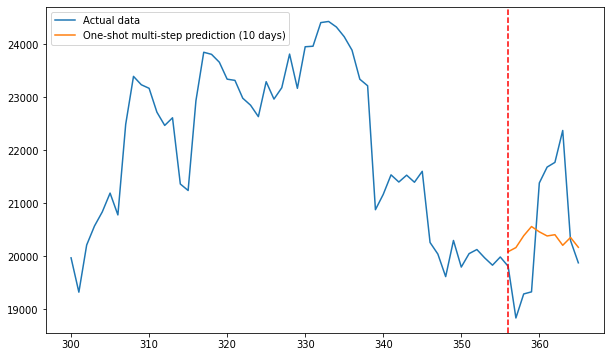

In [24]:
start_history = 300
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(start_history, len(y))]
plt.plot(a, y[start_history:], label='Actual data');
c = [x for x in range(len(y)-len_out_seq, len(y))]
plt.plot(c, test_predict, label=f'One-shot multi-step prediction ({len_out_seq} days)')
plt.axvline(x=len(y)-len_out_seq, c='r', linestyle='--')
plt.legend()
plt.show()